In [ ]:
# CELL 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 # For L2 regularization
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

# F1Score metric
try:
    from tensorflow.keras.metrics import F1Score
    f1_score_metric = F1Score(average='macro', name='f1_score')
    MONITOR_METRIC = 'val_f1_score'
except ImportError:
    print("F1Score not found in tf.keras.metrics. Using Precision and Recall as fallback.")
    from tensorflow.keras.metrics import Precision, Recall
    f1_score_metric = [Precision(name='precision'), Recall(name='recall')]
    MONITOR_METRIC = 'val_recall' # Monitor recall as a proxy for F1

In [ ]:
# CELL 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CELL 3: Define Constants and Paths
TRAIN_DIR = '/content/drive/MyDrive/corn_train/train' # ADJUST THIS PATH

IMG_WIDTH = 260
IMG_HEIGHT = 260
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

NUM_CLASSES = 4
BATCH_SIZE = 32
SEED = 123

In [ ]:
# CELL 4: Load and Preprocess Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 3360 files belonging to 4 classes.
Using 2688 files for training.
Found 3360 files belonging to 4 classes.
Using 672 files for validation.
Class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
# CELL 5: Calculate Class Weights to Address Imbalance
counts = {
    'Blight': 917,
    'Common_Rust': 1045,
    'Gray_Leaf_Spot': 459,
    'Healthy': 929
}
ordered_counts = np.array([counts[name] for name in class_names])
total_samples = np.sum(ordered_counts)
class_weights_calculated = {}
for i, class_name in enumerate(class_names):
    weight = total_samples / (NUM_CLASSES * ordered_counts[i])
    class_weights_calculated[i] = weight
print("Calculated Class Weights:", class_weights_calculated)

Calculated Class Weights: {0: np.float64(0.9133042529989095), 1: np.float64(0.8014354066985646), 2: np.float64(1.8246187363834423), 3: np.float64(0.9015069967707212)}


In [ ]:
# CELL 6: Configure Dataset for Performance
AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000, seed=SEED)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds) # Val ds is also shuffled by this func, which is fine.
                                         # Caching and prefetching are more important for val.

In [ ]:
# CELL 7: Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical', seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.RandomZoom(0.2, seed=SEED),
    layers.RandomContrast(0.2, seed=SEED),
], name='data_augmentation')

In [ ]:
# CELL 8: Build the Model with EfficientNetV2B2 (Adjusted Dropout and L2 Regularization)

base_model_efficientnet = EfficientNetV2B2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model_efficientnet.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE, name='input_layer')
x = data_augmentation(inputs)
x = base_model_efficientnet(x, training=False)
x = layers.BatchNormalization(name='batch_norm_top')(x)
x = layers.Dropout(0.35, name='top_dropout')(x)
# --- Added L2 Regularization to Dense Layer ---
outputs = layers.Dense(
    NUM_CLASSES,
    activation='softmax',
    kernel_regularizer=l2(1e-4), # Added L2 regularization
    name='output_layer'
)(x)

model_efficientnet_exp = tf.keras.Model(inputs, outputs) # Renamed to avoid conflict if rerunning cells

metrics_to_use_exp = ['categorical_accuracy']
if isinstance(f1_score_metric, list):
    metrics_to_use_exp.extend(f1_score_metric)
else:
    metrics_to_use_exp.append(f1_score_metric)

model_efficientnet_exp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=metrics_to_use_exp
)
model_efficientnet_exp.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 1408)           │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_top                  │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         5,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,780,642 (33.50 MB)

 Trainable params: 8,452 (33.02 KB)

 Non-trainable params: 8,772,190 (33.46 MB)

In [ ]:
# CELL 9: Define Callbacks (Monitoring the chosen F1 proxy or direct F1 score)
early_stopping_exp = EarlyStopping(
    monitor=MONITOR_METRIC, # Use the globally defined monitor metric
    patience=10, # Can be adjusted, e.g., slightly more patience for fine-tuning
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr_exp = ReduceLROnPlateau(
    monitor=MONITOR_METRIC,
    factor=0.2,
    patience=5, # Reduce LR if no improvement for 5 epochs
    verbose=1,
    mode='max',
    min_lr=1e-7
)
callbacks_list_exp = [early_stopping_exp, reduce_lr_exp]

In [ ]:
# CELL 10: Initial Training (Train only the top layers)
EPOCHS_INITIAL_EXP = 20

print("--- Initial Experimental Training (Top Layers) ---")
history_efficientnet_initial_exp = model_efficientnet_exp.fit(
    train_ds,
    epochs=EPOCHS_INITIAL_EXP,
    validation_data=val_ds,
    callbacks=callbacks_list_exp,
    class_weight=class_weights_calculated
)

--- Initial Experimental Training (Top Layers) ---
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 438ms/step - categorical_accuracy: 0.6609 - f1_score: 0.6353 - loss: 0.9873 - val_categorical_accuracy: 0.8705 - val_f1_score: 0.8407 - val_loss: 0.4544 - learning_rate: 0.0010
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - categorical_accuracy: 0.8569 - f1_score: 0.8266 - loss: 0.4095 - val_categorical_accuracy: 0.9048 - val_f1_score: 0.8859 - val_loss: 0.3197 - learning_rate: 0.0010
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - categorical_accuracy: 0.8806 - f1_score: 0.8602 - loss: 0.3397 - val_categorical_accuracy: 0.9167 - val_f1_score: 0.8977 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - categorical_accuracy: 0.8862 - f1_score: 0.8625 - loss: 0.3478 - val_categorical_accuracy: 0.9271 - val_f1_score: 0.9124 - val_loss: 0.2320 - learning_rate: 0.0010
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - categorical_accuracy: 0.89

In [ ]:
# CELL 11: Fine-Tuning (Adjusted: Unfreeze fewer layers)

base_model_efficientnet.trainable = True

# --- Recommendation: Freeze more layers (unfreeze fewer) during fine-tuning ---
# Unfreeze only the top 20% of layers in the base model for this experiment
# Adjust this percentage based on results. A smaller percentage means fewer trainable params.
fine_tune_at_exp = int(len(base_model_efficientnet.layers) * 0.80)

for layer in base_model_efficientnet.layers[:fine_tune_at_exp]:
    layer.trainable = False
for layer in base_model_efficientnet.layers[fine_tune_at_exp:]:
    layer.trainable = True # Ensure these are actually trainable

model_efficientnet_exp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Keep low LR for fine-tuning
    loss=CategoricalCrossentropy(),
    metrics=metrics_to_use_exp
)
print("--- Model Summary After Setting Layers for Fine-Tuning ---")
model_efficientnet_exp.summary()

EPOCHS_FINE_TUNE_EXP = 15
total_epochs_exp = EPOCHS_INITIAL_EXP + EPOCHS_FINE_TUNE_EXP

print("--- Experimental Fine-Tuning ---")
# Determine the correct initial_epoch for continuing training
# If initial training ran for full EPOCHS_INITIAL_EXP:
initial_epoch_for_finetuning = EPOCHS_INITIAL_EXP
# If initial training was stopped early by EarlyStopping:
if history_efficientnet_initial_exp.epoch: # Check if training history exists
    initial_epoch_for_finetuning = history_efficientnet_initial_exp.epoch[-1] + 1


history_efficientnet_fine_tune_exp = model_efficientnet_exp.fit(
    train_ds,
    epochs=total_epochs_exp,
    initial_epoch=initial_epoch_for_finetuning,
    validation_data=val_ds,
    callbacks=callbacks_list_exp, # Can reuse callbacks
    class_weight=class_weights_calculated
)

--- Model Summary After Setting Layers for Fine-Tuning ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 1408)           │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_top                  │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         5,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,780,642 (33.50 MB)

 Trainable params: 3,297,876 (12.58 MB)

 Non-trainable params: 5,482,766 (20.92 MB)

--- Experimental Fine-Tuning ---
Epoch 21/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - categorical_accuracy: 0.9030 - f1_score: 0.9009 - loss: 0.2935 - val_categorical_accuracy: 0.9256 - val_f1_score: 0.9113 - val_loss: 0.2093 - learning_rate: 1.0000e-05
Epoch 22/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - categorical_accuracy: 0.9010 - f1_score: 0.8821 - loss: 0.2918 - val_categorical_accuracy: 0.9435 - val_f1_score: 0.9324 - val_loss: 0.1838 - learning_rate: 1.0000e-05
Epoch 23/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - categorical_accuracy: 0.9033 - f1_score: 0.8825 - loss: 0.3124 - val_categorical_accuracy: 0.9405 - val_f1_score: 0.9285 - val_loss: 0.1843 - learning_rate: 1.0000e-05
Epoch 24/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - categorical_accuracy: 0.9119 - f1_score: 0.8900 - loss: 0.2524 - val_categorical_accuracy: 0.9405 - val_f1_score: 0.9280 - val_loss: 0.1728 - learning_rate: 1.0000e-05
Epoch 25/35
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - categorical_accuracy: 0

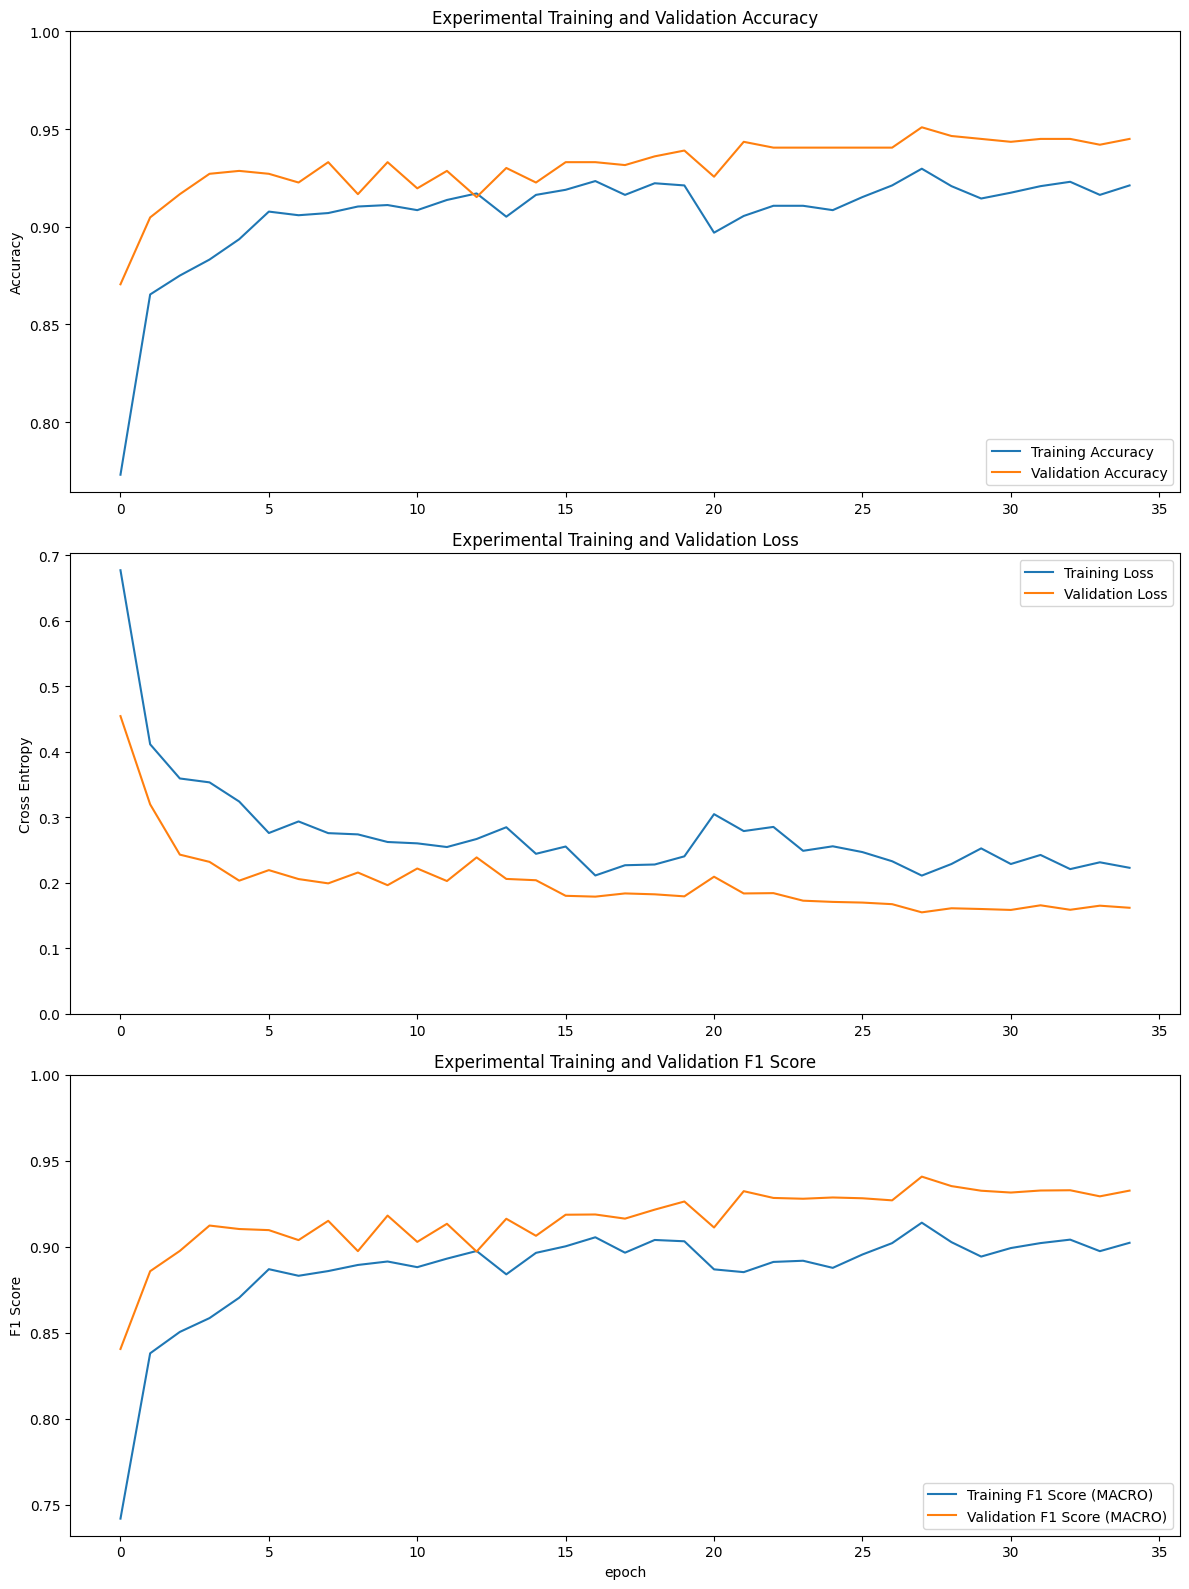

In [ ]:
# CELL 12: Plot Training History
if history_efficientnet_initial_exp.history and history_efficientnet_fine_tune_exp.history:
    acc_exp = history_efficientnet_initial_exp.history['categorical_accuracy'] + history_efficientnet_fine_tune_exp.history['categorical_accuracy']
    val_acc_exp = history_efficientnet_initial_exp.history['val_categorical_accuracy'] + history_efficientnet_fine_tune_exp.history['val_categorical_accuracy']

    loss_exp = history_efficientnet_initial_exp.history['loss'] + history_efficientnet_fine_tune_exp.history['loss']
    val_loss_exp = history_efficientnet_initial_exp.history['val_loss'] + history_efficientnet_fine_tune_exp.history['val_loss']

    f1_metric_key = 'f1_score' # Default if F1Score object was used
    val_f1_metric_key = 'val_f1_score'

    # Check if fallback metrics (precision/recall) were used
    if 'precision' in history_efficientnet_initial_exp.history:
        precision_exp = history_efficientnet_initial_exp.history['precision'] + history_efficientnet_fine_tune_exp.history['precision']
        val_precision_exp = history_efficientnet_initial_exp.history['val_precision'] + history_efficientnet_fine_tune_exp.history['val_precision']
        recall_exp = history_efficientnet_initial_exp.history['recall'] + history_efficientnet_fine_tune_exp.history['recall']
        val_recall_exp = history_efficientnet_initial_exp.history['val_recall'] + history_efficientnet_fine_tune_exp.history['val_recall']
        f1_available = False
    elif f1_metric_key in history_efficientnet_initial_exp.history:
        f1_exp = history_efficientnet_initial_exp.history[f1_metric_key] + history_efficientnet_fine_tune_exp.history[f1_metric_key]
        val_f1_exp = history_efficientnet_initial_exp.history[val_f1_metric_key] + history_efficientnet_fine_tune_exp.history[val_f1_metric_key]
        f1_available = True
    else: # Should not happen if metrics were set up correctly
        print("F1 score or Precision/Recall keys not found in history.")
        f1_available = False


    plt.figure(figsize=(12, 16 if f1_available else 12)) # Adjust figure size

    plt.subplot(3 if f1_available else 2, 1, 1)
    plt.plot(acc_exp, label='Training Accuracy')
    plt.plot(val_acc_exp, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Experimental Training and Validation Accuracy')

    plt.subplot(3 if f1_available else 2, 1, 2)
    plt.plot(loss_exp, label='Training Loss')
    plt.plot(val_loss_exp, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim()) if plt.ylim() else 1]) # Handle empty ylim
    plt.title('Experimental Training and Validation Loss')

    if f1_available:
        plt.subplot(3, 1, 3)
        plt.plot(f1_exp, label=f'Training F1 Score ({f1_score_metric.average.upper() if hasattr(f1_score_metric, "average") else "Macro"})')
        plt.plot(val_f1_exp, label=f'Validation F1 Score ({f1_score_metric.average.upper() if hasattr(f1_score_metric, "average") else "Macro"})')
        plt.legend(loc='lower right')
        plt.ylabel('F1 Score')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Experimental Training and Validation F1 Score')
        plt.xlabel('epoch')
    elif 'precision' in history_efficientnet_initial_exp.history : # Plot P & R if F1 not direct
        plt.figure(figsize=(12, 8)) # New figure for P & R
        plt.subplot(2, 1, 1)
        plt.plot(precision_exp, label='Training Precision')
        plt.plot(val_precision_exp, label='Validation Precision')
        plt.legend(loc='lower right')
        plt.ylabel('Precision')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Experimental Training and Validation Precision')

        plt.subplot(2, 1, 2)
        plt.plot(recall_exp, label='Training Recall')
        plt.plot(val_recall_exp, label='Validation Recall')
        plt.legend(loc='lower right')
        plt.ylabel('Recall')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Experimental Training and Validation Recall')
        plt.xlabel('epoch')

    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting. Ensure training cells were run.")

In [ ]:
# CELL 13: Evaluate on Validation Set
print("--- Evaluating Experimental Model ---")
results_exp = model_efficientnet_exp.evaluate(val_ds, batch_size=BATCH_SIZE, verbose=1)

print("\nExperimental Validation Loss, Accuracy, F1/Precision/Recall:")
for name, value in zip(model_efficientnet_exp.metrics_names, results_exp):
    print(f"{name}: {value:.4f}")

if 'f1_score' not in model_efficientnet_exp.metrics_names:
    print("\nCalculating F1 score from predictions on validation set (Experimental)...")
    y_pred_val_exp = []
    y_true_val_exp = []
    for images, labels in val_ds: # Iterate to get all predictions
        y_true_val_exp.extend(np.argmax(labels.numpy(), axis=1))
        y_pred_val_exp.extend(np.argmax(model_efficientnet_exp.predict(images, verbose=0), axis=1))

    from sklearn.metrics import classification_report, f1_score
    print("\nExperimental Validation Classification Report:")
    print(classification_report(y_true_val_exp, y_pred_val_exp, target_names=class_names, zero_division=0))

    macro_f1_exp = f1_score(y_true_val_exp, y_pred_val_exp, average='macro', zero_division=0)
    weighted_f1_exp = f1_score(y_true_val_exp, y_pred_val_exp, average='weighted', zero_division=0)
    print(f"Macro F1 Score (Experimental Validation): {macro_f1_exp:.4f}")
    print(f"Weighted F1 Score (Experimental Validation): {weighted_f1_exp:.4f}")

--- Evaluating Experimental Model ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.9488 - f1_score: 0.9344 - loss: 0.1492

Experimental Validation Loss, Accuracy, F1/Precision/Recall:
loss: 0.1550
compile_metrics: 0.9509

Calculating F1 score from predictions on validation set (Experimental)...

Experimental Validation Classification Report:
                precision    recall  f1-score   support

        Blight       0.93      0.92      0.92       189
   Common_Rust       0.98      0.95      0.97       197
Gray_Leaf_Spot       0.83      0.93      0.88        88
       Healthy       1.00      0.99      1.00       198

      accuracy                           0.95       672
     macro avg       0.94      0.95      0.94       672
  weighted avg       0.95      0.95      0.95       672

Macro F1 Score (Experimental Validation): 0.9409
Weighted F1 Score (Experimental Validation): 0.9516


In [ ]:
# CELL 14: Save the Final Experimental Model
MODEL_SAVE_PATH_EXP = '/content/drive/MyDrive/CornLeaf_EfficientNetv2b2.keras' # Adjust
model_efficientnet_exp.save(MODEL_SAVE_PATH_EXP)
print(f"Experimental model saved to {MODEL_SAVE_PATH_EXP}")

Experimental model saved to /content/drive/MyDrive/CornLeaf_EfficientNetv2b2.keras
